## Zhong et al model 

In this example we compare the zhong model at 129x65 node resolution with the two weak-zone based models. One uses a transversely isotropic viscosity model to impose a frictional-surface contraint on the shear-stress / normal stress ration for integration points close to the fault zone, the other uses an isotropic viscosity to impose a granular-friction constraint on the 2nd invariant of the total stress tensor for points close the the fault zone. 




In [1]:
import underworld as uw
from underworld import function as fn

import glucifer
from easydict import EasyDict as edict


uw.matplotlib_inline()
import sys

# import matplotlib.pyplot as pyplot
# import matplotlib.pylab as pylab
import numpy as np
import math
import os


/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/usr/local/lib/python2.7/dist-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag()

In [2]:

workdir = os.path.abspath(".")
outputPath = os.path.join(workdir,"output")


if uw.rank() == 0:
    if not os.path.exists(outputPath):
        os.makedirs(outputPath)
    
uw.barrier()   


In [3]:

pd = edict({}) #parameters dictionary
md = edict({}) #model setup, numerics, etc


#pd = edict({'fthickness':0.0075,      
#            'friction_mu':0.00001,
#            'friction_C':0.00001,
#            'friction_min':0.00001})
            

pd = edict({'fthickness':0.015,      
            'friction_mu':0.001,
            'friction_C':0.0002,
            'friction_min':0.001,
            'orientation':30.,
            'deltaViscosity':1000.,
            'viscosity':1.,
            'deltaViscosity':100.,
            'w0':4.,
             })
    

md = edict({'RES':64,
            'elementType':"Q1/dQ0"})



In [4]:
#Model number identifier default:
ModNum = 0

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Pass

In [5]:
###########
#If extra arguments are provided to the script" eg:
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3=3.0
###########

for farg in sys.argv[1:]:
    try:
        (dicitem,val) = farg.split("=") #Split on equals operator
        (dic,arg) = dicitem.split(".") #colon notation
        if '*=' in farg:
            (dicitem,val) = farg.split("*=") #If in-place multiplication, split on '*='
            (dic,arg) = dicitem.split(".")
            
        if val == 'True': 
            val = True
        elif val == 'False':     #First check if args are boolean
            val = False
        else:
            try:
                val = float(val) #next try to convert  to a float,
            except ValueError:
                pass             #otherwise leave as string
        #Update the dictionary
        if farg.startswith('pd'):
            if '*=' in farg:
                pd[arg] = pd[arg]*val #multiply parameter by given factor
            else:
                pd[arg] = val    #or reassign parameter by given value
        if farg.startswith('md'):
            if '*=' in farg:
                md[arg] = md[arg]*val #multiply parameter by given factor
            else:
                md[arg] = val    #or reassign parameter by given value
                
    except:
        pass
            

uw.barrier()

In [6]:
print("parameter dictionary: ", pd)
print("model dictionary: ", md)

('parameter dictionary: ', {'friction_mu': 0.001, 'orientation': 30.0, 'friction_min': 0.001, 'viscosity': 1.0, 'friction_C': 0.0002, 'deltaViscosity': 100.0, 'fthickness': 0.015, 'w0': 4.0})
('model dictionary: ', {'RES': 64, 'elementType': 'Q1/dQ0'})


## Model

In [7]:
#def run_the_fault(num=1, fthickness = 0.0075, friction_mu = 0.00001, friction_C  = 0.00001, friction_min = 0.00001):

outputFile = 'results_' + str(ModNum) + '.dat'

minX  =  0.0;   minY = 0.0
maxX  =  2.0;   maxY = 1.0


resY = int(md.RES)
resX = int(resY*2)

#"Q1/dQ0"  
#"Q2/dpc1"
elementType = md.elementType

mesh = uw.mesh.FeMesh_Cartesian( elementType = (elementType), 
                                 elementRes  = ( resX, resY), 
                                 minCoord    = ( minX, minY), 
                                 maxCoord    = ( maxX, maxY),
                                 periodic    = [False, False]  ) 


velocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:]   = [0.,0.]
pressureField.data[:]   = 0.


refVelocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
refPressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

refVelocityField.data[:]   = [0.,0.]
refPressureField.data[:]   = 0.

wzVelocityField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
wzPressureField    = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

wzVelocityField.data[:]   = [0.,0.]
wzPressureField.data[:]   = 0.


# Define strain rate tensor

strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )
strainRate_2ndInvariantFn = fn.tensor.second_invariant(strainRateFn)

wzStrainRateFn = fn.tensor.symmetric( wzVelocityField.fn_gradient )
wzStrainRate_2ndInvariantFn = fn.tensor.second_invariant(wzStrainRateFn)

refStrainRateFn = fn.tensor.symmetric( refVelocityField.fn_gradient )
refStrainRate_2ndInvariantFn = fn.tensor.second_invariant(refStrainRateFn)

#Coordinate functions

coordinate = fn.input()
depthFn = maxY - coordinate[1] #a function providing the depth
   

In [8]:
#####
#BCs
#####
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]

baseWall   = mesh.specialSets["MinJ_VertexSet"]
topWall    = mesh.specialSets["MaxJ_VertexSet"]

freeslipBC = uw.conditions.DirichletCondition( variable        = velocityField, 
                                               indexSetsPerDof = (iWalls, jWalls) )     


In [9]:
#####
#Swarm
#####
swarm  = uw.swarm.Swarm( mesh=mesh, particleEscape=True )
swarmLayout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=swarm, particlesPerCell=50 )
swarm.populate_using_layout( layout=swarmLayout )

# Population control may be useful

pop_control = uw.swarm.PopulationControl(swarm, aggressive=True, particlesPerCell=50)

advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
# Tracking different materials etc
materialVariable       = swarm.add_variable( dataType="int", count=1 )
# Tracking the fault information
proximityVariable      = swarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = swarm.add_variable( dataType="float", count=1 )
directorVector   = swarm.add_variable( dataType="double", count=2)

directorVector.data[:,:] = 0.0
proximityVariable.data[:] = 0
signedDistanceVariable.data[:] = 0.0


#####
#Material Dist. 
#####
materialA  = 0 # accommodation layer a.k.a. Sticky Air
materialV  = 1 # Rigid blocks

yCoord = fn.coord()[1]

conditions = [ (       yCoord > 1.1 ,                      materialA ),
               (       yCoord < 0.0  ,                     materialA ),
               (       True ,                              materialV ) ]

materialVariable.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)

In [10]:
#####
#Faults 
#####
from marker2D import markerLine2D
#from unsupported.interfaces import markerLine2D
faults = []

forientation = np.radians(pd.orientation)
flength    = 0.35355
fstart = 1.375
faultLine1 = (fstart, 1.0)
faultLine2 = (faultLine1[0] + flength * np.cos(forientation), faultLine1[1]-flength*np.sin(forientation) )

faultLineXs = np.linspace(faultLine1[0], faultLine2[0], 50)
faultLineYs = np.linspace(faultLine1[1], faultLine2[1], 50)

# Build a fault object out of this

fault_seg1  = markerLine2D(mesh, velocityField, faultLineXs, faultLineYs, pd.fthickness, 0.0, 0.0, 1)
faults.append(fault_seg1)

uw.barrier()

def update_swarm_from_faults(faults, proximityVariable, normalVectorVariable, signedDistanceVariable):
    """
    Compute fault attributes from the marker-line objects in the 'faults' list.
    Specifically:

      - proximityVariable carries information about which fault each swarm particle is close to (0 means none)
      - normalVectorVariable maps the orientation of the fault to nearby swarm particles
      - signedDistanceVariable carries the distance (positive means 'inside')  

      Unchecked error: if these variables are from different swarms 

    """

    for fault_seg in faults:

        swarm = proximityVariable.swarm

        f, nz = fault_seg.compute_marker_proximity(swarm.particleCoordinates.data)    
        proximityVariable.data[nz] = f[nz]

        dv, nzv = fault_seg.compute_normals(swarm.particleCoordinates.data)
        normalVectorVariable.data[nzv] = dv[nzv]

        sd, dnz = fault_seg.compute_signed_distance(swarm.particleCoordinates.data)
        signedDistanceVariable.data[dnz] = sd[dnz]

    return


def mask_materials(material, materialVariable, proximityVariable, normalVectorVariable, signedDistanceVariable):

    fptsMaskOut = np.where(materialVariable.data[:,0] != material)[0]

    normalVectorVariable.data[fptsMaskOut,:] = [0.0,0.0]
    proximityVariable.data[fptsMaskOut] = 0
    signedDistanceVariable.data[fptsMaskOut] = 0.0


def fault_strainrate_fns(fault_list, velocityField, faultNormalVariable, proximityproVariable):

    ## This is a quick / short cut way to find the resolved stress components.

    strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )


    #  n1 * edot_11 * n1 + 
    #  n2 * edot_21 * n1 + 
    #  n1 * edot_21 * n2 +
    #  n2 * edot_22 * n2 

#     _edotn_SFn = ( directorVector[0] * strainRateFn[0] * directorVector[0] + 
#                    directorVector[1] * strainRateFn[2] * directorVector[0] + # Symmetry !! 
#                    directorVector[0] * strainRateFn[2] * directorVector[1] + 
#                    directorVector[1] * strainRateFn[1] * directorVector[1]                          
#                 )


    ## "OPTIMIZED" VERSION

    _edotn_SFn = (        directorVector[0]**2 * strainRateFn[0]  + 
                    2.0 * directorVector[1]    * strainRateFn[2] * directorVector[0] + 
                          directorVector[1]**2 * strainRateFn[1]                          
                ) 

    # any non-zero proximity requires the computation of the above

    _edotn_SFn_Map    = { 0: 0.0 }
    for f in fault_list:
        _edotn_SFn_Map[f.ID] =  _edotn_SFn


    #  s1 = -n2
    #  s2 =  n1
    #
    # -n2 * edot_11 * n1 + 
    #  n1 * edot_21 * n1 + 
    # -n2 * edot_21 * n2 + 
    #  n1 * edot_22 * n2     

#     _edots_SFn = ( -directorVector[1] * strainRateFn[0] * directorVector[0] + 
#                     directorVector[0] * strainRateFn[2] * directorVector[0] + 
#                    -directorVector[1] * strainRateFn[2] * directorVector[1] + 
#                     directorVector[0] * strainRateFn[1] * directorVector[1] 
#                 )

    ## "OPTIMIZED" VERSION


    _edots_SFn = (  directorVector[0] *  directorVector[1] *(strainRateFn[1] - strainRateFn[0]) +
                    strainRateFn[2] * (directorVector[0]**2 - directorVector[1]**2)
                 )


    _edots_SFn_Map = { 0: 1.0e-15 }

    for f in fault_list:
        _edots_SFn_Map[f.ID] =  _edots_SFn


    edotn_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edotn_SFn_Map)


    edots_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edots_SFn_Map )


    return edotn_SFn, edots_SFn





## Call the Fault helper functions 

update_swarm_from_faults(faults, proximityVariable, directorVector, signedDistanceVariable)
mask_materials(materialV, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

# These should be general enough not to need updating when the faults move etc

edotn_SFn, edots_SFn = fault_strainrate_fns(faults, velocityField, directorVector, proximityVariable)


In [34]:
mesh.reset()

sig = 0.25

coord = fn.input()
def disGen(centre):
    
    offsetFn = coord - centre
    return fn.math.sqrt((0.5*offsetFn[0])**2. + offsetFn[1]**2.)



centreX = (mesh.maxCoord[0] - mesh.minCoord[0])/2.
centreY = (mesh.maxCoord[1] - mesh.minCoord[1])/2.
fXdist = 1.0*sig*(faultLineXs.mean() - centreX)/centreX
fYdist = 0.5*sig*(faultLineYs.mean() - centreY)/centreY

centreX = faultLineXs.mean() - fXdist
centreY = faultLineYs.mean() - fYdist

dFn = disGen((centreX, centreY))


gammaFn =  fn.math.exp(-fn.math.pow(dFn, 2.) / (2. * fn.math.pow(sig, 2.)))



gammaFn  = fn.branching.conditional(  ( (dFn < sig,  1.),
                                              (        True, 0.)   ) )


gammaFn *= 1.
gammaFn += 1.




In [35]:
#Fields to store mesh refinement stuff on
yField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
yField.data[:] = 0.

yBC = uw.conditions.DirichletCondition( variable=yField, indexSetsPerDof=(jWalls,) )

xField = uw.mesh.MeshVariable( mesh=mesh, nodeDofCount=1 )
xField.data[:] = 0.

xBC = uw.conditions.DirichletCondition( variable=xField, indexSetsPerDof=(iWalls,) )

# set bottom wall temperature bc
for index in mesh.specialSets["MinJ_VertexSet"]:
    yField.data[index] = mesh.minCoord[1]
# set top wall temperature bc
for index in mesh.specialSets["MaxJ_VertexSet"]:
    yField.data[index] = mesh.maxCoord[1]
    
# set bottom wall temperature bc
for index in mesh.specialSets["MinI_VertexSet"]:
    xField.data[index] = mesh.minCoord[0]
## set top wall temperature bc
for index in mesh.specialSets["MaxI_VertexSet"]:
    xField.data[index] = mesh.maxCoord[0]
    

yLaplaceEquation = uw.systems.SteadyStateHeat(temperatureField=yField, fn_diffusivity=gammaFn, conditions=[yBC,])
xLaplaceEquation = uw.systems.SteadyStateHeat(temperatureField=xField, fn_diffusivity=gammaFn, conditions=[xBC,])


# get the default heat equation solver
yLaplaceSolver = uw.systems.Solver(yLaplaceEquation)
# solve
yLaplaceSolver.solve()


# get the default heat equation solver
xLaplaceSolver = uw.systems.Solver(xLaplaceEquation)
# solve
xLaplaceSolver.solve()

In [36]:
mesh.reset()

#Get the array of Y positions - copy may be necessary, not sure. 
newYpos = yField.data.copy()
newXpos = xField.data.copy() 


uw.barrier()
with mesh.deform_mesh():
    mesh.data[:,0] = newXpos[:,0]
    mesh.data[:,1] = newYpos[:,0]
    
swarm.update_particle_owners()


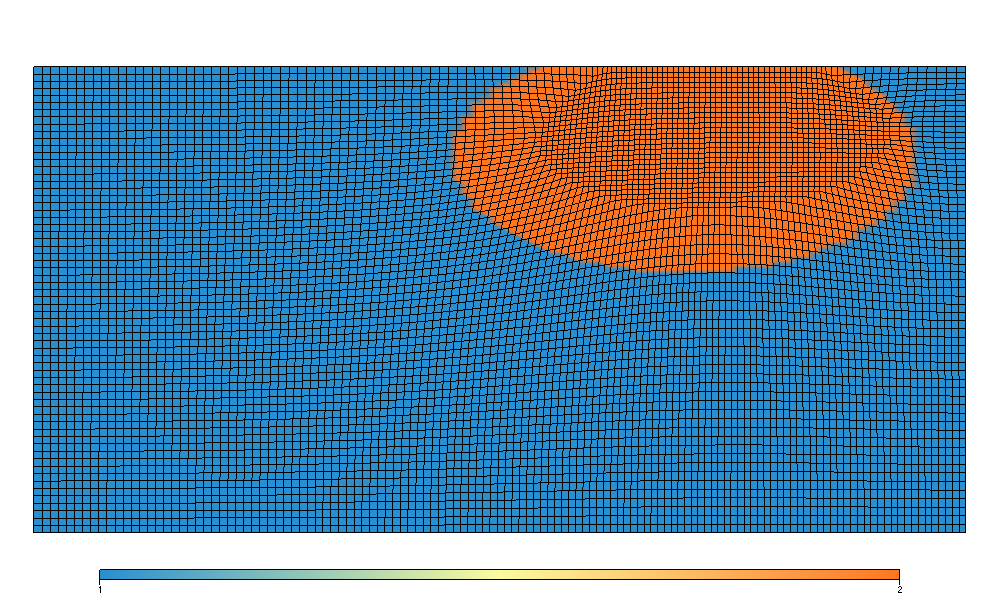

In [44]:
fig= glucifer.Figure( figsize=(1000,600) )
fig.append( glucifer.objects.Mesh(mesh))
fig.append( glucifer.objects.Surface(mesh, gammaFn))
fig.show()

In [16]:
#####
#Rheology
#####
viscosity   = pd.viscosity
deltaViscosity = pd.deltaViscosity
expDepthConstant = fn.misc.constant(math.log(deltaViscosity))

#friction_mu = 0.00001 #in function 
#friction_C  = 0.00001 #in function 

#minimum viscosity associated with tangential shear rate
#friction_min = 0.00001 in function 

delta_f_min = 1. - pd.friction_min




ageProxyFn = ((fn.misc.constant(fstart) - fn.math.abs(fn.coord()[0] - fstart))/fstart) + 1e-15
tempProxyFn = fn.math.erf((depthFn*pd.w0)/(2.*fn.math.sqrt(ageProxyFn)))
firstViscosityFn   = pd.deltaViscosity*fn.math.exp(-1.*math.log(pd.deltaViscosity)*tempProxyFn)

# Now the second viscosity (for shear)

# 2nd Viscosity is defined by delta eta (0.0 means isotropic)

# Delta Visc 

viscosityTI2_fn = fn.misc.min(firstViscosityFn*delta_f_min, fn.misc.max(0.0, 
                     firstViscosityFn - (pd.friction_mu * (-edotn_SFn * firstViscosityFn + pressureField)  + pd.friction_C) / (fn.math.abs(edots_SFn) + 1.0e-15)))




# This one maps to the fault-proximity variable 

viscosity2Map    = { 0: 0.0, 
                     1: viscosityTI2_fn, 
                     2: viscosityTI2_fn                   
                   }

secondViscosityFn  = fn.branching.map( fn_key  = proximityVariable, 
                                       mapping = viscosity2Map )


viscosityDP_fn = fn.misc.min(firstViscosityFn, fn.misc.max(pd.friction_min, 
                     (pd.friction_mu * pressureField  + pd.friction_C) / (strainRate_2ndInvariantFn + 1.0e-15)))


viscosityWZMap   = { 0: firstViscosityFn,
                     1: viscosityDP_fn, 
                     2: viscosityDP_fn }


viscosityWZFn       =  fn.branching.map( fn_key  = proximityVariable, 
                                         mapping = viscosityWZMap )

In [17]:
#####
#Buoyancy and Stokes
#####
z_hat = ( 0.0, 1.0 )
Ra = fn.misc.constant(1.0)

T_fn = fn.misc.constant(0.01) *  fn.math.cos(np.pi/maxX * fn.coord()[0]) * fn.math.sin(np.pi * fn.coord()[1])
buoyancyFn = z_hat * T_fn



# Build a reference case
stokesPIC1 = uw.systems.Stokes( velocityField  = velocityField, 
                               pressureField  = pressureField,
                               conditions     = [freeslipBC,],
                               fn_viscosity   = firstViscosityFn, 
                               fn_bodyforce   = buoyancyFn )

solver    = uw.systems.Solver( stokesPIC1 )

solver.set_inner_method("mumps")
solver.set_penalty(1.0e6)
solver.options.scr.ksp_rtol = 1.0e-6

solver.solve( nonLinearIterate=False, print_stats=False)

refVelocityField.data[:,:] = velocityField.data[:,:]
refPressureField.data[:]   = pressureField.data[:]

del solver
del stokesPIC1

# Build a weak zone equivalent case
velocityField.data[...] = 0.0
pressureField.data[...] = 0.0

stokesPIC1 = uw.systems.Stokes( velocityField  = velocityField, 
                               pressureField  = pressureField,
                               conditions     = [freeslipBC,],
                               fn_viscosity   = viscosityWZFn, 
                               fn_bodyforce   = buoyancyFn )

solver    = uw.systems.Solver( stokesPIC1 )

solver.set_inner_method("mumps")
solver.set_penalty(1.0e6)
solver.options.scr.ksp_rtol = 1.0e-6

solver.solve( nonLinearIterate=True, nonLinearTolerance=0.00001, print_stats=False)

wzVelocityField.data[:,:] = velocityField.data[:,:]
wzPressureField.data[:]   = pressureField.data[:]

del solver
del stokesPIC1


# The anisotropic case 
velocityField.data[...] = 0.0
pressureField.data[...] = 0.0

stokesPIC = uw.systems.Stokes( velocityField  = velocityField, 
                               pressureField  = pressureField,
                               conditions     = [freeslipBC,],
                               fn_viscosity   = firstViscosityFn, 
                              _fn_viscosity2  = secondViscosityFn,
                              _fn_director    = directorVector,                         
                               fn_bodyforce   = buoyancyFn )

solver    = uw.systems.Solver( stokesPIC )
solver.set_inner_method("mumps")
solver.set_penalty(1.0e6)
solver.options.scr.ksp_rtol = 1.0e-6

solver.solve( nonLinearIterate=True, nonLinearTolerance=0.00001, print_stats=False )


uw.barrier()   


In [18]:
#pressureField.evaluate_global(mesh).max() 
#thisGuy = fn.view.min_max(pressureField)
#thisGuy.evaluate(mesh)
#pd.friction_C /(thisGuy.max_global()*pd.friction_mu)

In [19]:
#####
#Metrics and Output
#####

def volumeint(Fn = 1., rFn=1.):
    return uw.utils.Integral( Fn*rFn,  mesh )


def surfint(Fn = 1., rFn=1., surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]):
    return uw.utils.Integral( Fn*rFn, mesh=mesh, integrationType='Surface', surfaceIndexSet=surfaceIndexSet)


#First we create some swarm variables that we'll set to 0 or 1, 
#which will help compute integrals on restricted portions of the domain

onefaultRestFn = swarm.add_variable( dataType="double", count=1 )
onefaultRestFn.data[:] = 0.

if not fault_seg1.empty: #Can only call fault.kdtree on procs holding part of the fault swarm
    onefaultRestFn.data[:,0] = fault_seg1.kdtree.query(swarm.particleCoordinates.data)[0][:]
    onefaultRestFn.data[np.where(onefaultRestFn.data > pd.fthickness)] = 1.
    onefaultRestFn.data[np.where(onefaultRestFn.data <= pd.fthickness)] = 0. 
    
    
halffaultRestFn = swarm.add_variable( dataType="double", count=1 )
halffaultRestFn.data[:] = 0.

if not fault_seg1.empty: #Can only call fault.kdtree on procs holding part of the fault swarm
    halffaultRestFn.data[:,0] = fault_seg1.kdtree.query(swarm.particleCoordinates.data)[0][:]
    halffaultRestFn.data[np.where(halffaultRestFn.data > 0.5*pd.fthickness)] = 1.
    halffaultRestFn.data[np.where(halffaultRestFn.data <= 0.5*pd.fthickness)] = 0. 
    
twofaultRestFn = swarm.add_variable( dataType="double", count=1 )
twofaultRestFn.data[:] = 0.

if not fault_seg1.empty: #Can only call fault.kdtree on procs holding part of the fault swarm
    twofaultRestFn.data[:,0] = fault_seg1.kdtree.query(swarm.particleCoordinates.data)[0][:]
    twofaultRestFn.data[np.where(twofaultRestFn.data > 2.*pd.fthickness)] = 1.
    twofaultRestFn.data[np.where(twofaultRestFn.data <= 2.*pd.fthickness)] = 0
    
oneelementRestFn = swarm.add_variable( dataType="double", count=1 )
oneelementRestFn.data[:] = 0.

if not fault_seg1.empty: #Can only call fault.kdtree on procs holding part of the fault swarm
    oneelementRestFn.data[:,0] = fault_seg1.kdtree.query(swarm.particleCoordinates.data)[0][:]
    oneelementRestFn.data[np.where(oneelementRestFn.data > 1.0/(resY+1.))] = 1.
    oneelementRestFn.data[np.where(oneelementRestFn.data <= 1.0/(resY+1.))] = 0.
    
halfelementRestFn = swarm.add_variable( dataType="double", count=1 )
halfelementRestFn.data[:] = 0.

if not fault_seg1.empty: #Can only call fault.kdtree on procs holding part of the fault swarm
    halfelementRestFn.data[:,0] = fault_seg1.kdtree.query(swarm.particleCoordinates.data)[0][:]
    halfelementRestFn.data[np.where(halfelementRestFn.data > 0.5/(resY+1.))] = 1.
    halfelementRestFn.data[np.where(halfelementRestFn.data <= 0.5/(resY+1.))] = 0. 
    
    
twoelementRestFn = swarm.add_variable( dataType="double", count=1 )
twoelementRestFn.data[:] = 0.

if not fault_seg1.empty: #Can only call fault.kdtree on procs holding part of the fault swarm
    twoelementRestFn.data[:,0] = fault_seg1.kdtree.query(swarm.particleCoordinates.data)[0][:]
    twoelementRestFn.data[np.where(twoelementRestFn.data > 2.0/(resY+1.))] = 1.
    twoelementRestFn.data[np.where(twoelementRestFn.data <= 2.0/(resY+1.))] = 0. 
    
    
    
###################
#Surface Restriction functions
###################

def platenessFn(vField, val = 0.1):
    normgradV = fn.math.abs(vField.fn_gradient[0]/fn.math.sqrt(vField[0]*vField[0])) #[du*/dx]/sqrt(u*u)



    srconditions = [ (                                  normgradV < val, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(srconditions)


srRestFnRef = platenessFn(refVelocityField, val = 0.1)
srRestFnUw = platenessFn(velocityField, val = 0.1)
srRestFnWz = platenessFn(wzVelocityField, val = 0.1)



#Dot product of the residual velocity field

Vuwr = velocityField-refVelocityField
Vwzr = wzVelocityField-refVelocityField
Vuwwz = velocityField-wzVelocityField

deltaVuwr  = fn.misc.min(1.0, fn.math.dot(Vuwr,  Vuwr))
deltaVwzr  = fn.misc.min(1.0, fn.math.dot(Vwzr,  Vwzr))
deltaVuwwz = fn.misc.min(1.0, fn.math.dot(Vuwwz,  Vuwwz))

#Set up the integrals

_area1 = volumeint(1.)                   #integration over entire domain
_area2 = volumeint(1., rFn=halffaultRestFn)
_area3 = volumeint(1., rFn=onefaultRestFn)  #integration restricted to area beyond one faultthickness from fault
_area4 = volumeint(1., rFn=twofaultRestFn)
_area5 = volumeint(1., rFn=halfelementRestFn)
_area6 = volumeint(1., rFn=oneelementRestFn) #integration restricted to area beyond one element away from fault
_area7 = volumeint(1., rFn=twoelementRestFn)


_Vuwr1 = volumeint(deltaVuwr)
_Vuwr2 = volumeint(deltaVuwr, rFn=halffaultRestFn)
_Vuwr3 = volumeint(deltaVuwr, rFn=onefaultRestFn)
_Vuwr4 = volumeint(deltaVuwr, rFn=twofaultRestFn)
_Vuwr5 = volumeint(deltaVuwr, rFn=halfelementRestFn)
_Vuwr6 = volumeint(deltaVuwr, rFn=oneelementRestFn)
_Vuwr7 = volumeint(deltaVuwr, rFn=twoelementRestFn)


_Vwzr1 = volumeint(deltaVwzr)
_Vwzr2 = volumeint(deltaVwzr, rFn=halffaultRestFn)
_Vwzr3 = volumeint(deltaVwzr, rFn=onefaultRestFn)
_Vwzr4 = volumeint(deltaVwzr, rFn=twofaultRestFn)
_Vwzr5 = volumeint(deltaVwzr, rFn=halfelementRestFn)
_Vwzr6 = volumeint(deltaVwzr, rFn=oneelementRestFn)
_Vwzr7 = volumeint(deltaVwzr, rFn=twoelementRestFn)




_Vuwwz1 = volumeint(deltaVuwwz)
_Vuwwz2 = volumeint(deltaVuwwz, rFn=halffaultRestFn)
_Vuwwz3 = volumeint(deltaVuwwz, rFn=onefaultRestFn)
_Vuwwz4 = volumeint(deltaVuwwz, rFn=twofaultRestFn)
_Vuwwz5 = volumeint(deltaVuwwz, rFn=halfelementRestFn)
_Vuwwz6 = volumeint(deltaVuwwz, rFn=oneelementRestFn)
_Vuwwz7 = volumeint(deltaVuwwz, rFn=twoelementRestFn)



#Platy-ness measure
_platenessRef = surfint(srRestFnRef)
_platenessUw = surfint(srRestFnUw)
_platenessWz = surfint(srRestFnWz)




#Evaluate the integrals

area1 = _area1.evaluate()[0]
area2 = _area2.evaluate()[0]
area3 = _area3.evaluate()[0]

dVuwr1 = np.sqrt(_Vuwr1.evaluate()[0]) #TI - ref
dVuwr2 = np.sqrt(_Vuwr2.evaluate()[0])
dVuwr3 = np.sqrt(_Vuwr3.evaluate()[0])
dVuwr4 = np.sqrt(_Vuwr4.evaluate()[0])
dVuwr5 = np.sqrt(_Vuwr5.evaluate()[0])
dVuwr6 = np.sqrt(_Vuwr6.evaluate()[0])
dVuwr7 = np.sqrt(_Vuwr7.evaluate()[0])

dVwzr1 = np.sqrt(_Vwzr1.evaluate()[0]) #Wz - ref
dVwzr2 = np.sqrt(_Vwzr2.evaluate()[0])
dVwzr3 = np.sqrt(_Vwzr3.evaluate()[0])
dVwzr4 = np.sqrt(_Vwzr4.evaluate()[0])
dVwzr5 = np.sqrt(_Vwzr5.evaluate()[0])
dVwzr6 = np.sqrt(_Vwzr6.evaluate()[0])
dVwzr7 = np.sqrt(_Vwzr7.evaluate()[0])


dVuwwz1 = np.sqrt( _Vuwwz1.evaluate()[0]) #Ti - wz
dVuwwz2 = np.sqrt(_Vuwwz2.evaluate()[0])
dVuwwz3 = np.sqrt(_Vuwwz3.evaluate()[0])
dVuwwz4 = np.sqrt( _Vuwwz4.evaluate()[0])
dVuwwz5 = np.sqrt(_Vuwwz5.evaluate()[0])
dVuwwz6 = np.sqrt(_Vuwwz6.evaluate()[0])
dVuwwz7 = np.sqrt(_Vuwwz7.evaluate()[0])


platenessRef = _platenessRef.evaluate()[0]
platenessUw = _platenessUw.evaluate()[0]
platenessWz = _platenessWz.evaluate()[0]


#Also calculate the ratio of Cohesion to confinement-strength in the Drucker-Prager formulation
#pressureField.evaluate_global(mesh).max() 
#thisGuy = fn.view.min_max(pressureField)
#thisGuy.evaluate(mesh)
#c_dp = pd.friction_C /(thisGuy.max_global()*pd.friction_mu)
    
if uw.rank() == 0:
    f_o = open(os.path.join(outputPath, outputFile), 'a') 
    f_o.write((30*'%-15s ' + '\n') % (md.RES, md.elementType,
                                      pd.fthickness, pd.friction_mu, pd.friction_C, pd.friction_min,
                                      dVuwr1,dVuwr2,dVuwr3,dVuwr4,dVuwr5,dVuwr6, dVuwr7,
                                      dVwzr1,dVwzr2,dVwzr3,dVwzr4,dVwzr5,dVwzr6, dVwzr7,
                                      dVuwwz1, dVuwwz2, dVuwwz3,dVuwwz4, dVuwwz5, dVuwwz6, dVuwwz7,
                                      platenessRef, platenessUw,platenessWz ))
    f_o.close()

#print area1
#print area2
#print area3
if uw.rank()==0:
    print dVuwr1
    print dVuwr2
    print dVuwr3
    print dVwzr1
    print dVwzr2
    print dVwzr3
    print dVuwwz1
    print dVuwwz2
    print dVuwwz3

In [20]:
#yElementFix = 1./(resY + 1)
#xElementFix = 2./(resX + 1)
#dE = yElementFix*xElementFix #Crude measure of elemnt are per node (dA)

#bg_nodes = np.where(fault_seg1.kdtree.query(mesh.data)[0] > pd.fthickness)

#deltaVuwr  = fn.misc.min(1.0, fn.math.dot(Vuwr,  Vuwr))
#deltaVwzr  = fn.misc.min(1.0, fn.math.dot(Vwzr,  Vwzr))
#deltaVuwwz = fn.misc.min(1.0, fn.math.dot(Vuwwz,  Vuwwz))

#dVuwrF = np.sqrt( deltaVuwr.evaluate(mesh.data[bg_nodes])).sum()
#dVwzrF = np.sqrt( deltaVwzr.evaluate(mesh.data[bg_nodes])).sum()
#dVuwwzF = np.sqrt( deltaVuwwz.evaluate(mesh.data[bg_nodes])).sum()

#print dVuwr2, dVwzr2, dVuwwz2, dVuwrF*dE, dVwzrF*dE, dVuwwzF*dE

In [21]:
#print(dVuwr2, dVuwrF*dE)    #swarm intagration vs node summation
#print(dVwzr2, dVwzrF*dE)    
#print(dVuwwz2, dVuwwzF*dE) 

Once output as a a script, this notebook cam be used for a parameter sweep. 
For example, to run models with a combination (outer product) of different fault thickness, mesh resolution, and element types:


```
for a in 0.03 0.015 0.0075 0.00375
do
   for b in 32 64 128
   do
      for c in "Q1/dQ0" "Q2/dpc1"
      do
        docker run -v $PWD:/workspace  -i -t --rm dansand/underworld2-dev mpirun -np 4 python Fault_BuoyancyDriven-devel.py 1 pd.fthickness=$a md.RES=$b md.elementType=$c
      done
   done
done

```

### Comparison of 'masked' L2-norm via node summing, swarm integration


| Measure|  Node summing    | Swarm Int.        | Notes  | 
| ----- | ------------------ | ----------------- | -----  |
| TI-ref |  2.9904077129e-06 | 2.89617704796e-06 |   -    |
| WZ-ref  |  3.19641785284e-06 | 3.11754905069e-06 |   -    |
| TI-ref |  3.53800984835e-07 | 3.66782130797e-07 |     - |

* TI => velocity field with TI fault
* WZ => velocity field with isotropic fault
* ref => velocity field with no fault



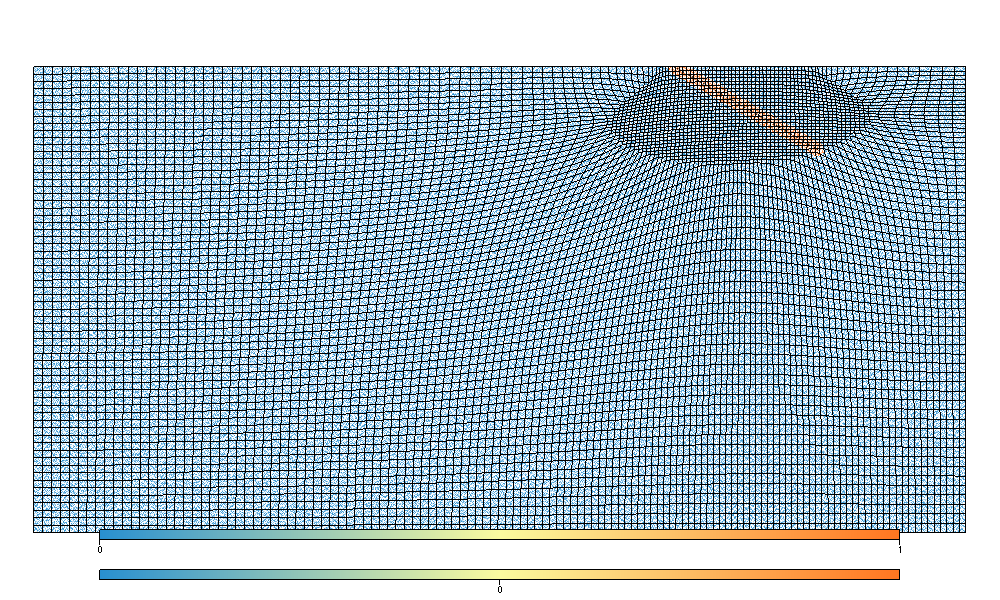

'test.gldb'

In [25]:
fig3= glucifer.Figure( figsize=(1000,600) )
fig3.append( glucifer.objects.Points(fault_seg1.swarm, pointSize=2 ) )
#fig3.append( glucifer.objects.Surface(mesh, firstViscosityFn) )
fig3.append( glucifer.objects.Points(swarm, proximityVariable, colourBar=True, pointSize=1 ) )
fig3.append( glucifer.objects.Mesh(mesh))
fig3.show()
fig3.save_database('test.gldb')

In [24]:
fig3.save_database('test.gldb')

'test.gldb'

In [75]:
#fig3= glucifer.Figure( figsize=(1000,600) )
#fig3.append( glucifer.objects.Surface(mesh, firstViscosityFn) )
#fig3.append( glucifer.objects.Points(fault_seg1.swarm, pointSize=2 ) )


#fig3.show()
#fig3.save_database('test.gldb')